In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from typing import Dict, Tuple, Optional, List
import json
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, r2_score
import warnings
import sys

sys.path.append('..')
from src.mert_util import *
warnings.filterwarnings('ignore')

In [6]:
# Load labels
labels_df = pd.read_parquet('../data/processed/core_dataset.parquet')
labels_df = labels_df.set_index('song_id')
labels_df.index = labels_df.index.astype(int)
    
print(f"Loaded {len(labels_df)} songs")
print(f"Valence: {labels_df['valence_mean'].mean():.3f} ± {labels_df['valence_mean'].std():.3f}")
print(f"Arousal: {labels_df['arousal_mean'].mean():.3f} ± {labels_df['arousal_mean'].std():.3f}")

Loaded 1802 songs
Valence: 4.904 ± 1.174
Arousal: 4.814 ± 1.282


In [7]:
from src.make_dataset.split_data import load_splits_triplet
train_ids, val_ids, test_ids = load_splits_triplet()

In [24]:
from src.mert_util import mert_deam_only, set_seed
set_seed(42)

model, hist_deam_only, test_metrics_deam_only = mert_deam_only(
    emb_dir=Path("../data/processed/mert_embeddings"),
    labels_df=labels_df, # index: song_id
    train_ids=train_ids, val_ids=val_ids, test_ids=test_ids,
    ckpt_path=Path("../results/mert/deam_only/best.ckpt"),
    metrics_path=Path("../results/mert/deam_only/test_metrics.json") # will save *test_metrics_deam_only.json*
)

MERT → DEAM-only
Best epoch 5 | val_loss=0.0413 | RMSE V/A=0.819/0.807 | R2 V/A=0.515/0.630
TEST RMSE(V/A) 0.876/0.861 | R2(V/A) 0.441/0.565


### Mert embeddings pre-training on Deezer -> Fine-tune on DEAM

In [18]:
# Load deezer csvs
deezer_train = pd.read_parquet('../data/Deezer/train.parquet')
deezer_val   = pd.read_parquet('../data/Deezer/val.parquet')
deezer_test  = pd.read_parquet('../data/Deezer/test.parquet')

# pretraining doesn't need testing, add the test set into the training set for bigger data input
deezer_train_full = pd.concat([deezer_train, deezer_test], ignore_index=True)
deezer_val = deezer_val.reset_index(drop=True)

deezer_df = pd.concat([deezer_train_full, deezer_val], ignore_index=True)
deezer_df['dzr_sng_id'] = deezer_df['dzr_sng_id'].astype(int)
deezer_df = deezer_df.drop_duplicates('dzr_sng_id', keep='last')[['dzr_sng_id','valence','arousal']]

deezer_train_ids = deezer_train_full['dzr_sng_id'].astype(int).tolist()
deezer_val_ids   = deezer_val['dzr_sng_id'].astype(int).tolist()
assert set(deezer_val_ids).isdisjoint(set(deezer_train_ids)), "Deezer val leaked into train"

In [12]:
from importlib import reload
from src import mert_util

reload(mert_util)

<module 'src.mert_util' from '/home/georgios/PGMP/notebooks/../src/mert_util.py'>

In [39]:
from src.mert_util import mert_deezer_pretrain_then_deam_finetune

m, hist, tm = mert_deezer_pretrain_then_deam_finetune(
    deezer_emb_dir=Path("../data/processed/DEEZER/mert_embeddings"),
    deezer_df=deezer_df, # cols: dzr_sng_id, valence, arousal
    deezer_train_ids=deezer_train_ids,
    deezer_val_ids=deezer_val_ids,
    deam_emb_dir=Path("../data/processed/mert_embeddings"),
    deam_labels=labels_df, # index: song_id
    deam_train_ids=train_ids, deam_val_ids=val_ids, deam_test_ids=test_ids,
    pre_ckpt=Path("../results/mert/pretrain/best.ckpt"),
    ft_ckpt=Path("../results/mert/finetune/best.ckpt"),
    metrics_path=Path("../results/mert/finetune/test_metrics.json") # will save *test_metrics_with_pretraining.json*
)

Pretrain on Deezer MERT → Finetune on DEAM MERT
Best epoch 7 | val_loss=0.0840 | RMSE V/A=0.933/0.802 | R2 V/A=0.224/0.281
Loaded pretrained head from ../results/mert/pretrain/best.ckpt
Best epoch 34 | val_loss=0.0402 | RMSE V/A=0.823/0.781 | R2 V/A=0.510/0.654
TEST RMSE(V/A) 0.872/0.871 | R2(V/A) 0.446/0.555


#### Plot histories and performance on test metrics

In [44]:
from src.viz_dl import *

saved: ../results/mert/plots/mert_val_rmse_v_pre_vs_ft.png


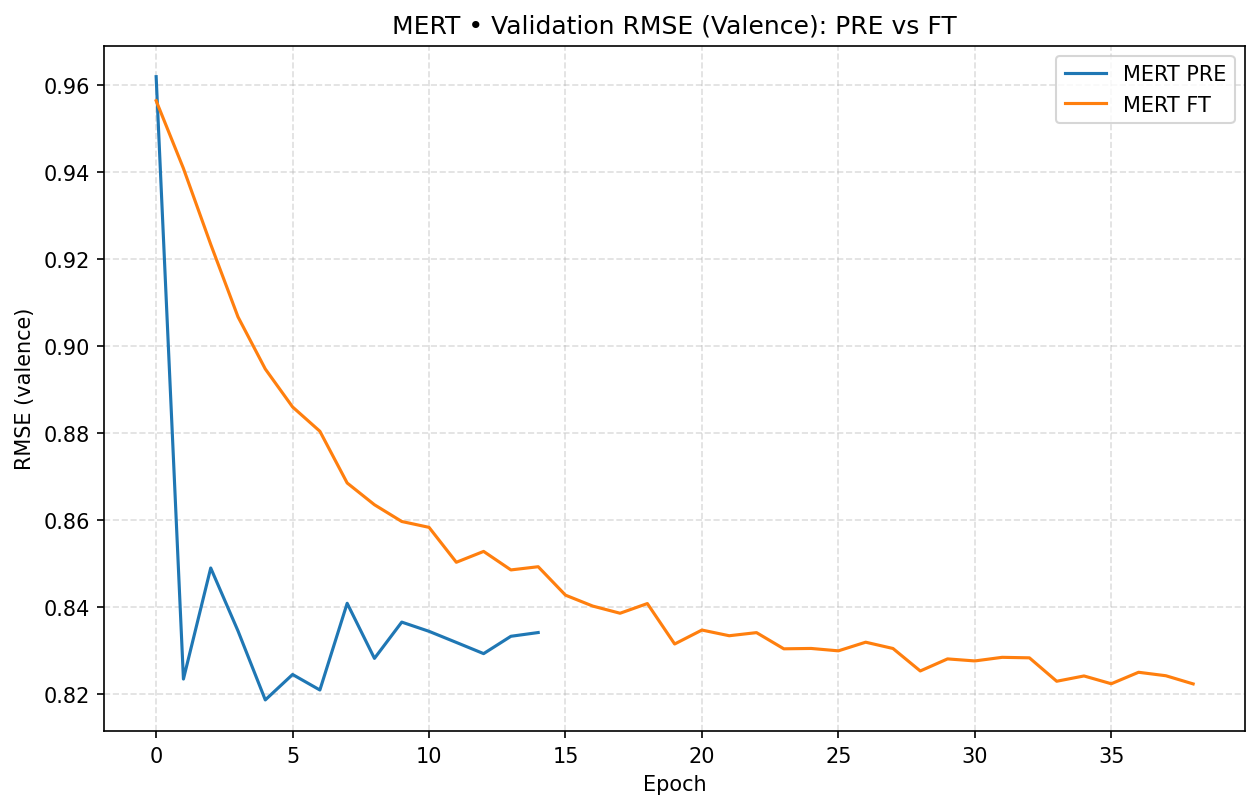

In [49]:
plot_histories_val_rmse(
    {"MERT PRE": hist_deam_only, "MERT FT": hist},
    title="MERT • Validation RMSE (Valence): PRE vs FT",
    savename=Path("../results/mert/plots/mert_val_rmse_v_pre_vs_ft.png")
)

In [50]:
results = load_results_from_jsons({
    "MERT-DEAM": "../results/mert/deam_only/test_metrics_deam_only.json",
    "MERT Deezer→DEAM (FT)": "../results/mert/finetune/test_metrics_with_pretraining.json",
})

saved: ../results/mert/plots/mert_test_metrics.png


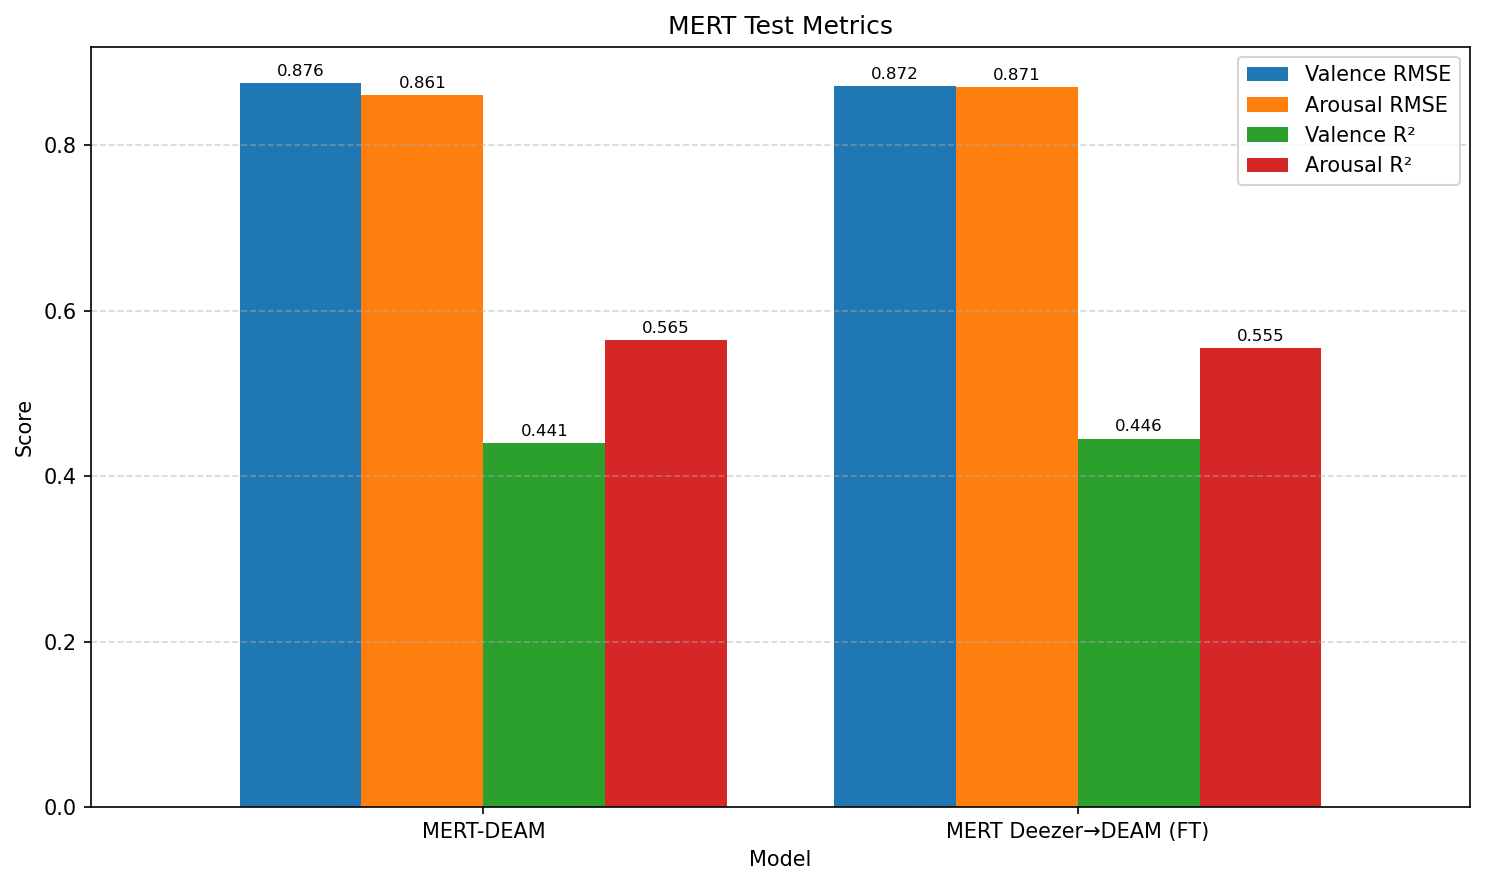

In [51]:
# bar chart
plot_results_bar(
    results,
    title="MERT Test Metrics",
    savename=Path("../results/mert/plots/mert_test_metrics.png")
)

### Test Mert Embeddings on original test split

In [52]:
train_ids, val_ids, test_ids = load_splits_triplet(name='original') # load the original DEAM splits (58 full song test set)

In [53]:
len(test_ids)

58

In [54]:
from src.mert_util import mert_deam_only, set_seed
set_seed(42)

model, hist_deam_only, test_metrics_deam_only = mert_deam_only(
    emb_dir=Path("../data/processed/mert_embeddings"),
    labels_df=labels_df, # index: song_id
    train_ids=train_ids, val_ids=val_ids, test_ids=test_ids,
    ckpt_path=Path("../results/mert/deam_only/best.ckpt"),
    metrics_path=Path("../results/mert/orig/deam_only/test_metrics.json") # will save *test_metrics_deam_only.json*
)

MERT → DEAM-only
Best epoch 15 | val_loss=0.0422 | RMSE V/A=0.840/0.803 | R2 V/A=0.512/0.611
TEST RMSE(V/A) 1.278/0.984 | R2(V/A) -0.165/0.109


In [55]:
# Add pretraining:
from src.mert_util import mert_deezer_pretrain_then_deam_finetune

m, hist, tm = mert_deezer_pretrain_then_deam_finetune(
    deezer_emb_dir=Path("../data/processed/DEEZER/mert_embeddings"),
    deezer_df=deezer_df, # cols: dzr_sng_id, valence, arousal
    deezer_train_ids=deezer_train_ids,
    deezer_val_ids=deezer_val_ids,
    deam_emb_dir=Path("../data/processed/mert_embeddings"),
    deam_labels=labels_df, # index: song_id
    deam_train_ids=train_ids, deam_val_ids=val_ids, deam_test_ids=test_ids,
    pre_ckpt=Path("../results/mert/pretrain/best.ckpt"),
    ft_ckpt=Path("../results/mert/finetune/best.ckpt"),
    metrics_path=Path("../results/mert/orig/finetune/test_metrics.json") # will save *test_metrics_with_pretraining.json*
)

Pretrain on Deezer MERT → Finetune on DEAM MERT
Best epoch 4 | val_loss=0.0838 | RMSE V/A=0.933/0.799 | R2 V/A=0.223/0.287
Loaded pretrained head from ../results/mert/pretrain/best.ckpt
Best epoch 37 | val_loss=0.0426 | RMSE V/A=0.811/0.841 | R2 V/A=0.546/0.572
TEST RMSE(V/A) 1.209/1.027 | R2(V/A) -0.044/0.029


In [56]:
results = load_results_from_jsons({
    "MERT-DEAM (orig)": "../results/mert/orig/deam_only/test_metrics_deam_only.json",
    "MERT Deezer→DEAM (orig)": "../results/mert/orig/finetune/test_metrics_with_pretraining.json",
})

saved: ../results/mert/plots/mert_test_metrics_orig.png


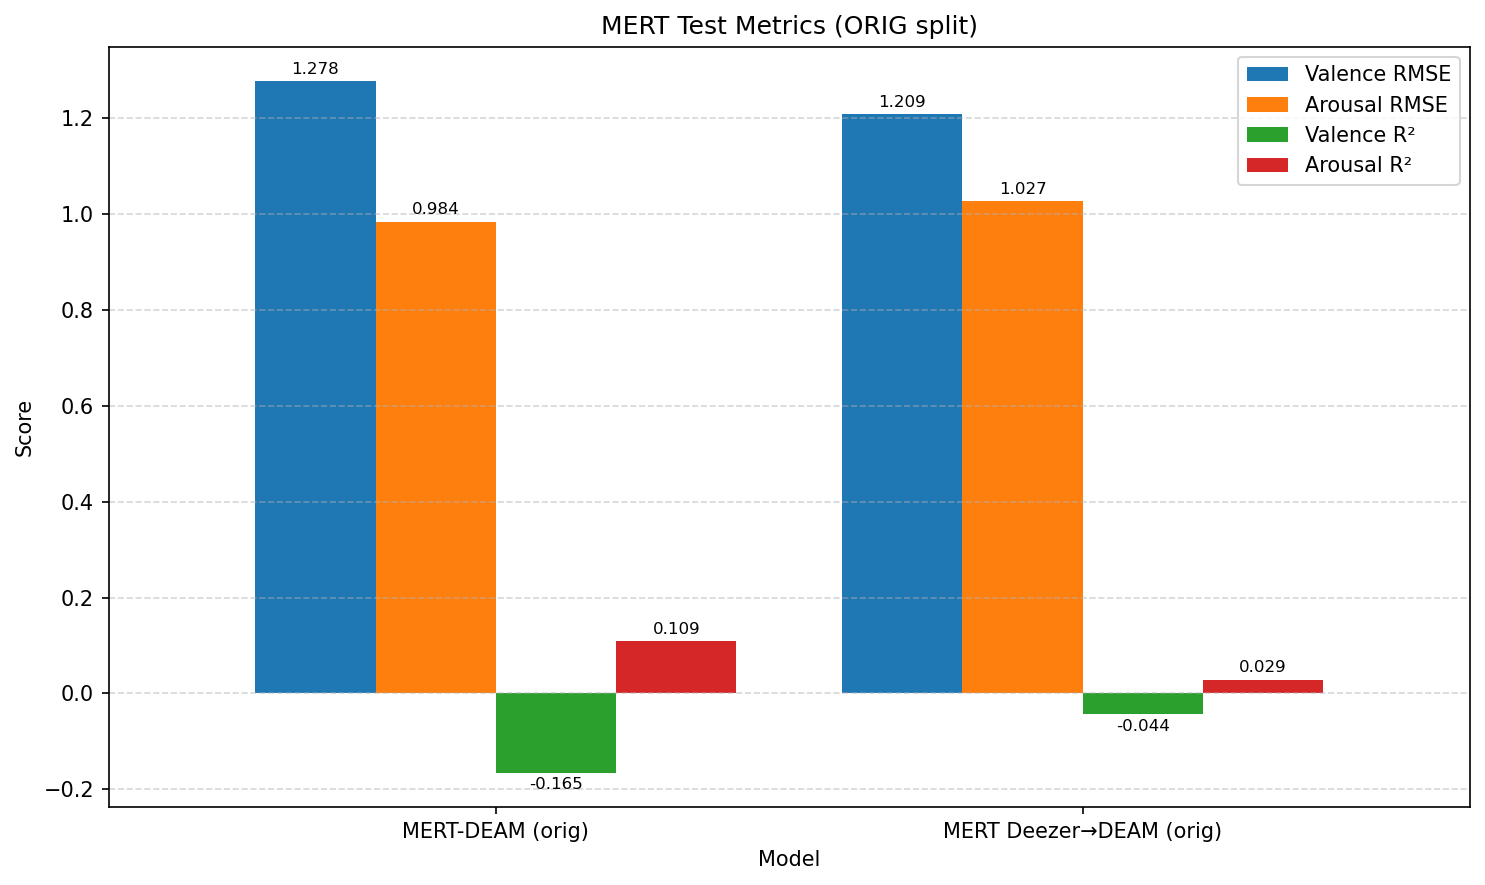

In [57]:
plot_results_bar(
    results,
    title="MERT Test Metrics (ORIG split)",
    savename=Path("../results/mert/plots/mert_test_metrics_orig.png")
)

### Evaluating Music2Emo zeroshot

In [8]:
from src.make_dataset.split_data import load_splits_triplet
train_ids, val_ids, test_ids = load_splits_triplet()
train_ids_og, val_ids_og, test_ids_og = load_splits_triplet(name='original') # load the original DEAM splits (58 full song test set)

In [9]:
print(len(test_ids), len(test_ids_og))

269 58


In [10]:
from src.DL_utils import evaluate_music2emo
print("\nEvaluating music2emo zero-shot on CUSTOM split")
embedding_dir = Path("../data/processed/mert_embeddings")
test_metrics_m2e = evaluate_music2emo(embedding_dir, labels_df, test_ids)


Evaluating music2emo zero-shot on CUSTOM split


Fetching 90 files:   0%|          | 0/90 [00:00<?, ?it/s]

music2emo inference: 100%|███████████████████████████████████████████████████████████| 269/269 [00:00<00:00, 535.35it/s]


In [15]:
out_json = Path("../results/mert/music2emo/test_metrics_custom_split.json")
save_test_json(out_json, test_metrics_m2e,
               extra={"dataset":"DEAM","model":"music2emo"},
               suffix="zeroshot")  # -> test_metrics_zeroshot.json

print(f"music2emo: RMSE V={test_metrics_m2e['rmse_v']:.3f} | A={test_metrics_m2e['rmse_a']:.3f} | "
      f"R² V={test_metrics_m2e['r2_v']:.3f} | R² A={test_metrics_m2e['r2_a']:.3f}")

music2emo: RMSE V=0.933 | A=0.818 | R² V=0.365 | R² A=0.607


In [16]:
print("\nEvaluating music2emo zero-shot on ORIG split")
embedding_dir = Path("../data/processed/mert_embeddings")
test_metrics_m2e = evaluate_music2emo(embedding_dir, labels_df, test_ids_og)


Evaluating music2emo zero-shot on ORIG split


Fetching 90 files:   0%|          | 0/90 [00:00<?, ?it/s]

music2emo inference: 100%|█████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 732.09it/s]


In [17]:
out_json = Path("../results/mert/music2emo/test_metrics_original_split.json")
save_test_json(out_json, test_metrics_m2e,
               extra={"dataset":"DEAM","model":"music2emo"},
               suffix="zeroshot")  # -> test_metrics_zeroshot.json

print(f"music2emo: RMSE V={test_metrics_m2e['rmse_v']:.3f} | A={test_metrics_m2e['rmse_a']:.3f} | "
      f"R² V={test_metrics_m2e['r2_v']:.3f} | R² A={test_metrics_m2e['r2_a']:.3f}")

music2emo: RMSE V=1.276 | A=0.811 | R² V=-0.162 | R² A=0.396


In [78]:
results = load_results_from_jsons({
    "music2emo ZS (custom)": "../results/mert/music2emo/test_metrics_custom_split_zeroshot.json",
    "music2emo ZS (orig)": "../results/mert/music2emo/test_metrics_original_split_zeroshot.json",
})

saved: ../results/mert/plots/mert_test_metrics_orig_with_music2emo.png


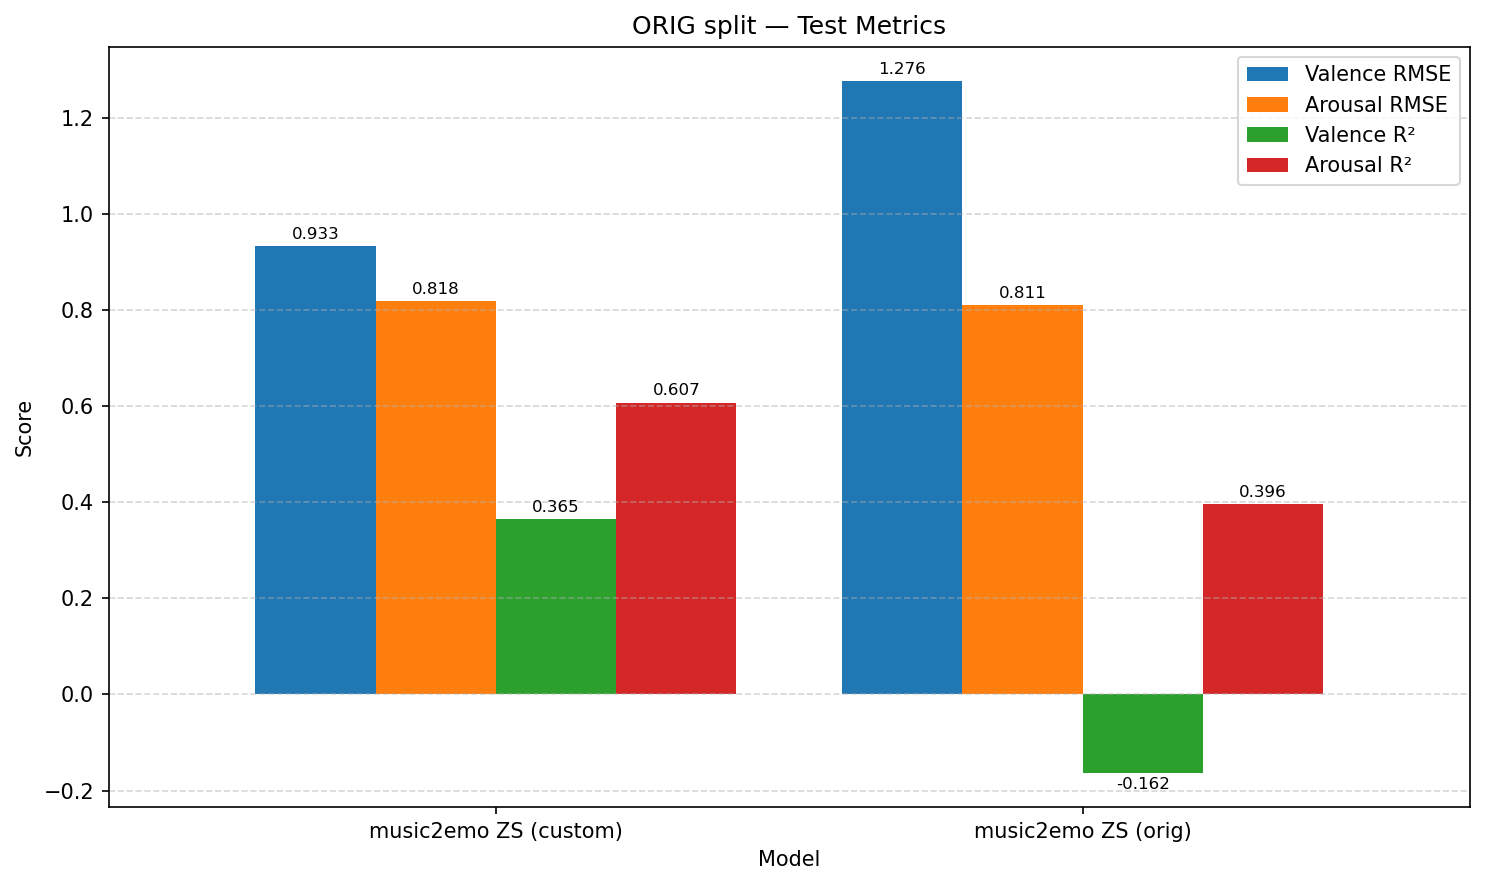

In [79]:
plot_results_bar(
    results,
    title="ORIG split — Test Metrics",
    savename=Path("../results/mert/plots/mert_test_metrics_orig_with_music2emo.png")
)